## Workshop 5: Optimisation Under Uncertainty

### 1. Installing and Importing Packages 

We first need to pull in all the packages we will be using. Pyomo is a Python-based, open-source optimization modelling language with a diverse set of optimization capabilities. For more information, see the Pyomo [documentation](https://pyomo.readthedocs.io/en/stable/).

In [1]:
# Only run once at the start
!pip install -q pyomo
!pip install -q matplotlib

In [2]:
import matplotlib.pyplot as plt
from pyomo.environ import *
import numpy as np
from ipywidgets import FloatSlider, interact
import platform
import scipy.stats as stats

# Ipopt solver setup for Windows or Linux
def setup_solver():
    os_name = platform.system()
    if os_name == "Windows":
        return "solver/ipopt.exe"
    elif os_name == "Linux":
        !chmod +x "solver/ipopt"
        return "solver/ipopt"


solver_executable = setup_solver()

### 2. Stochastic Optimisation

#### a. Parameter Uncertainty - Distribution Sampling

In [186]:
# Parameters for the EWibull distribution
alpha = 5     # Scale parameter
beta = 2      # Shape parameter

# Function to compute the PDF of the EWibull distribution
def ewibull_pdf(x, alpha, beta):
    if x < 0:
        return 0
    else:
        return (beta / alpha) * (x / alpha)**(beta - 1) * np.exp(-(x / alpha)**beta)

# Sample from the EWibull distribution
N_SAMPLES = 100
sample_list = []
for _ in range(N_SAMPLES):
    a = stats.weibull_min(beta, scale=alpha).rvs()  # Sample using the Weibull distribution
    p_a = ewibull_pdf(a, alpha, beta)  # PDF at the sample
    sample_list.append((a, p_a))

# Define the x range for the EWibull distribution
x = np.linspace(0, 16, 1000)  # Adjust the range based on your scale
y = [ewibull_pdf(i, alpha, beta) for i in x]  # Calculate PDF values

In [187]:
# Create a Pyomo model
model = ConcreteModel()

# Variables
model.x1 = Var(bounds=(1, 1000), domain=PositiveReals)
model.x2 = Var(domain=Reals)
model.y = Var(range(N_SAMPLES), bounds=(0, 1), within=Binary)

# Objective Function
@model.Objective(sense=minimize)
def objective_rule(model):
    return sum((a * p_a * model.x1 + model.x2) for a, p_a in sample_list)

M = 1000
# Loop to add multiple constraints based on uncertain values
def constraint_rule(model, i):
    a, _ = sample_list[i]  # Get 'a' from the sample_list
    return a * model.x1 + model.x2 >= -3 + M * (1-model.y[i])

# Create constraints using a loop
model.constraints = ConstraintList()
for i in range(N_SAMPLES):
    model.constraints.add(constraint_rule(model, i))

# Sum of y constraint
model.sum_y_constraint = Constraint(expr=sum(model.y[i] for i in range(N_SAMPLES)) >= 90)

# To solve the model
solver = SolverFactory('gurobi')  # Ensure Gurobi is installed
results = solver.solve(model)
constraints_violated = N_SAMPLES -sum(model.y[i].value for i in range(1,N_SAMPLES))

In [188]:
print(f"x1 optimal: {model.x1.value}")
print(f"x2 optimal: {model.x2.value}")
print(f"objective value: {model.objective_rule()}")
print(f"no. constraint violations: {constraints_violated}")

x1 optimal: 1.0
x2 optimal: -3.3641867637634277
objective value: -288.9439099113071
no. constraint violations: 1.0


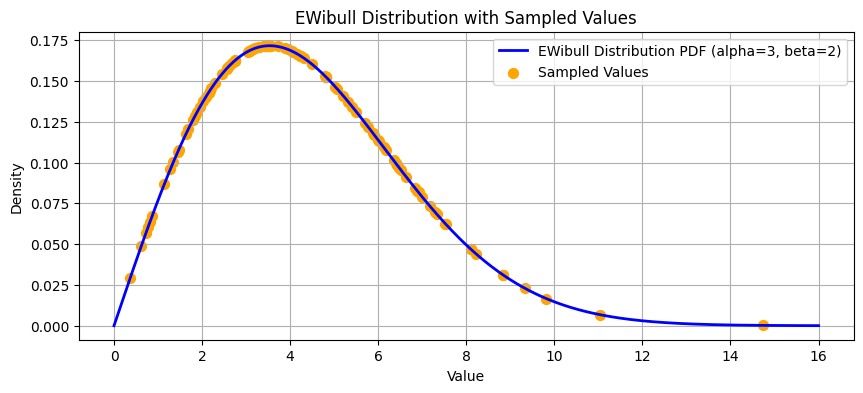

In [189]:
# Extract sampled values and their corresponding PDF values
sample_values = [a for a, _ in sample_list]
sample_pdf_values = [p_a for _, p_a in sample_list]  # PDF values at sampled points

# Create the plot
plt.figure(figsize=(10, 4))
plt.plot(x, y, label='EWibull Distribution PDF (alpha=3, beta=2)', color='blue', linewidth=2)
plt.scatter(sample_values, sample_pdf_values, color='orange', label='Sampled Values', marker='o', s=50)  # Plot samples at their PDF values
plt.title('EWibull Distribution with Sampled Values')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()


#### b. Inclusion of Extreme Distribution Values - Importance Sampling

So, from the graph above, we can see that through random sampling, we are not effectively capturing the tail end of our distribution. This is problematic when we want our solution to be robust to such extreme events, which may occur infrequently but can have a significant impact. If we simply rely on random sampling, we might miss these crucial points altogether, and even if we increase the number of samples to eventually capture the tail, the result would be a very large sample size, diluting the impact of these rare but important tail samples on the optimization.

**Importance Sampling Approach**

Instead of increasing the sample size indiscriminately, we can use importance sampling to address this issue. Importance sampling allows us to deliberately include tail-end samples while ensuring that they don't disproportionately affect the optimization process. The key idea is to adjust the contribution of each sample to account for the fact that some are more (or less) likely to occur in the real distribution.

In importance sampling, if we sample from a distribution $q(x)$, which may not be the same as the target distribution $p(x)$, we must adjust for this by assigning each sample a weight $w(x)$, calculated as:

$$
w(x)= \frac{q(x)}{p(x)}
$$

Where:
- $p(x)$ is the probability density function (PDF) of the target distribution, for example, a Weibull distribution.
- $q(x)$ is the PDF of the distribution from which the sample was actually drawn (which could include tail samples deliberately).
- $w(x)$ is the importance weight that adjusts the contribution of each sample.

In [190]:
def weibull_ppf(p, alpha, beta):
    """Compute the inverse CDF (ppf) of the Weibull distribution."""
    return alpha * (-np.log(1 - p)) ** (1 / beta)

def sample_weibull_tail(alpha, beta, num_samples, tail_percentile=99.9):
    # Get the 95th percentile (or user-specified tail starting point) from the inverse CDF
    tail_cutoff = weibull_ppf(tail_percentile / 100, alpha, beta)
    
    # Generate num_samples values only in the tail of the distribution
    tail_samples = []
    for _ in range(num_samples):
        # Keep generating until the value is in the tail
        while True:
            u = np.random.uniform(0, 1)  # Random sample from uniform distribution
            a = weibull_ppf(u, alpha, beta)  # Get corresponding Weibull sample
            if a >= tail_cutoff:
                p_a = ewibull_pdf(a, alpha, beta)  # Get PDF value for the sample
                tail_samples.append((a, p_a))
                break  # Once a valid tail sample is found, stop looping for this iteration
    
    return tail_samples

# Example usage
tail_samples = sample_weibull_tail(alpha, beta, num_samples=10)

#### Visualise Importance Sampling

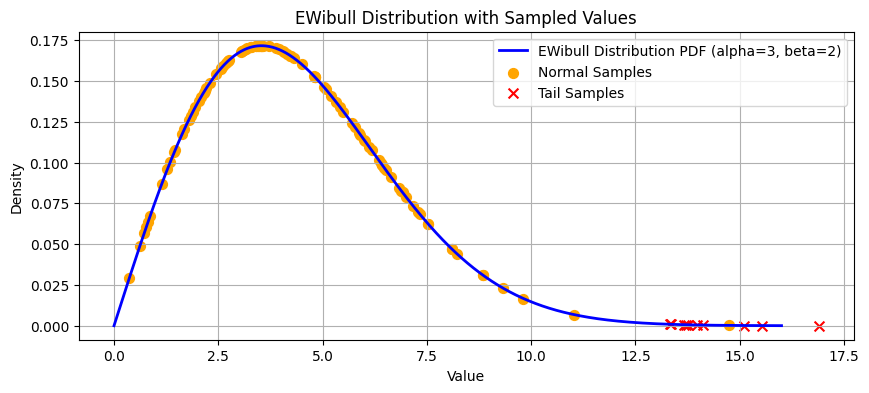

In [191]:
# Combine normal and tail samples
normal_samples = [sample for sample in sample_list if sample not in tail_samples]
tail_samples = tail_samples  # This should already be defined

# Extract sampled values and their corresponding PDF values
normal_sample_values = [a for a, _ in normal_samples]
normal_sample_pdf_values = [p_a for _, p_a in normal_samples]

tail_sample_values = [a for a, _ in tail_samples]
tail_sample_pdf_values = [p_a for _, p_a in tail_samples]

# Create the plot
plt.figure(figsize=(10, 4))
plt.plot(x, y, label='EWibull Distribution PDF (alpha=3, beta=2)', color='blue', linewidth=2)

# Plot normal samples
plt.scatter(normal_sample_values, normal_sample_pdf_values, color='orange', label='Normal Samples', marker='o', s=50)

# Plot tail samples
plt.scatter(tail_sample_values, tail_sample_pdf_values, color='red', label='Tail Samples', marker='x', s=50)

plt.title('EWibull Distribution with Sampled Values')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()


In [192]:
# Combine random and tail samples
importance_sampling = sample_list + tail_samples

# Importance weights: Assume that the extreme points are sampled using a different method (q(x))
# Example: Assume q(x) is uniform distribution over a certain range (this depends on how you sampled extreme points)
q_dist = stats.uniform(loc=0, scale=1)

# Create a set of tail sample values for efficient lookup
tail_sample_values = {a for a, _ in tail_samples}

# Calculate importance weights
importance_weights = [(p_a / q_dist.pdf(a)) if a in tail_sample_values else 1.0 for a, p_a in sample_list]

# Create a Pyomo model
model = ConcreteModel()

# Variables
model.x1 = Var(bounds=(1, 1000), domain=PositiveReals)
model.x2 = Var(domain=Reals)
model.y = Var(range(len(sample_list)), bounds=(0, 1), within=Binary)

# Objective Function: Scale the contribution of each sample by its importance weight
@model.Objective(sense=minimize)
def objective_rule(model):
    return sum(importance_weights[i] * (a * p_a * model.x1 + model.x2)
               for i, (a, p_a) in enumerate(sample_list))

M = 100
# Loop to add multiple constraints based on uncertain values
def constraint_rule(model, i):
    a, _ = sample_list[i]  # Get 'a' from the sample_list
    return a * model.x1 + model.x2 >= -3 + M * (1 - model.y[i])

# Create constraints using a loop
model.constraints = ConstraintList()
for i in range(len(sample_list)):
    model.constraints.add(constraint_rule(model, i))

# Sum of y constraint
model.sum_y_constraint = Constraint(expr=sum(model.y[i] for i in range(len(sample_list))) >= 99)

# To solve the model
solver = SolverFactory('gurobi')
results = solver.solve(model)

In [193]:
print(f"x1 optimal: {model.x1.value}")
print(f"x2 optimal: {model.x2.value}")
print(f"objective value: {model.objective_rule()}")
print(f"no. constraint violations: {constraints_violated}")

x1 optimal: 1.0
x2 optimal: -3.3641867637634277
objective value: -288.9439099113071
no. constraint violations: 1.0
